In [1]:
from PIL import Image
import numpy as np
from itertools import cycle
import random
import sys

import pygame
from pygame.locals import *
from flappy_agent_v3_reducemore_qlearn import agent
import pickle

SCREENWIDTH  = 288
SCREENHEIGHT = 512
# amount by which base can maximum shift to left
PIPEGAPSIZE  = 150 # gap between upper and lower part of pipe
BASEY        = SCREENHEIGHT * 0.79
SNAPSHOT_INTERVAL=4
SNAPSHOT_MAX=15000
SNAPSHOT_PATH="snapshot/np_128square_without_label.pickle"
agent.snapshot_list=[]
# image, sound and hitmask  dicts
IMAGES, HITMASKS = {}, {}

# list of all possible players (tuple of 3 positions of flap)
PLAYERS_LIST = (
    # red bird
    (
        'assets/sprites/redbird-upflap.png',
        'assets/sprites/redbird-midflap.png',
        'assets/sprites/redbird-downflap.png',
    ),
)

# list of backgrounds
BACKGROUNDS_LIST = (
    'assets/sprites/background-day.png',
)

# list of pipes
PIPES_LIST = (
    'assets/sprites/pipe-green.png',
)


try:
    xrange
except NameError:
    xrange = range


def main():
    global SCREEN, FPSCLOCK, FPS
    FPS=30
    pygame.init()
    pygame.font.init()
    myfont = pygame.font.SysFont('Comic Sans MS', 20)
    FPSCLOCK = pygame.time.Clock()
    SCREEN = pygame.display.set_mode((SCREENWIDTH, SCREENHEIGHT))
    pygame.display.set_caption('Flappy Bird')

    # numbers sprites for score display
    IMAGES['numbers'] = (
        pygame.image.load('assets/sprites/0.png').convert_alpha(),
        pygame.image.load('assets/sprites/1.png').convert_alpha(),
        pygame.image.load('assets/sprites/2.png').convert_alpha(),
        pygame.image.load('assets/sprites/3.png').convert_alpha(),
        pygame.image.load('assets/sprites/4.png').convert_alpha(),
        pygame.image.load('assets/sprites/5.png').convert_alpha(),
        pygame.image.load('assets/sprites/6.png').convert_alpha(),
        pygame.image.load('assets/sprites/7.png').convert_alpha(),
        pygame.image.load('assets/sprites/8.png').convert_alpha(),
        pygame.image.load('assets/sprites/9.png').convert_alpha()
    )

    # game over sprite
    IMAGES['gameover'] = pygame.image.load('assets/sprites/gameover.png').convert_alpha()
    # message sprite for welcome screen
    IMAGES['message'] = pygame.image.load('assets/sprites/message.png').convert_alpha()
    # base (ground) sprite
    IMAGES['base'] = pygame.image.load('assets/sprites/base.png').convert_alpha()

    ai_switch=0
    while True:
        # select random background sprites
        randBg = 0
        IMAGES['background'] = pygame.image.load(BACKGROUNDS_LIST[randBg]).convert()

        # select random player sprites
        randPlayer = 0
        IMAGES['player'] = (
            pygame.image.load(PLAYERS_LIST[randPlayer][0]).convert_alpha(),
            pygame.image.load(PLAYERS_LIST[randPlayer][1]).convert_alpha(),
            pygame.image.load(PLAYERS_LIST[randPlayer][2]).convert_alpha(),
        )

        # select random pipe sprites
        pipeindex = 0
        IMAGES['pipe'] = (
            pygame.transform.rotate(
                pygame.image.load(PIPES_LIST[pipeindex]).convert_alpha(), 180),
            pygame.image.load(PIPES_LIST[pipeindex]).convert_alpha(),
        )

        # hismask for pipes
        HITMASKS['pipe'] = (
            getHitmask(IMAGES['pipe'][0]),
            getHitmask(IMAGES['pipe'][1]),
        )

        # hitmask for player
        HITMASKS['player'] = (
            getHitmask(IMAGES['player'][0]),
            getHitmask(IMAGES['player'][1]),
            getHitmask(IMAGES['player'][2]),
        )
        
        
        if ai_switch==0:
            movementInfo = showWelcomeAnimation()
        if ai_switch==2:
            pass
        pygame.display.update()
        crashInfo = mainGame(movementInfo)
        ai_switch=showGameOverScreen(crashInfo)


def showWelcomeAnimation():
    """Shows welcome screen animation of flappy bird"""
    myfont = pygame.font.SysFont('Comic Sans MS', 12)
    FPS=30
    # index of player to blit on screen
    playerIndex = 0
    playerIndexGen = cycle([0, 1, 2, 1])
    # iterator used to change playerIndex after every 5th iteration
    loopIter = 0

    playerx = 64
    playery = int((SCREENHEIGHT - IMAGES['player'][0].get_height()) / 2)

    messagex = int((SCREENWIDTH - IMAGES['message'].get_width()) / 2)
    messagey = int(SCREENHEIGHT * 0.12)

    basex = 0
    # amount by which base can maximum shift to left
    baseShift = IMAGES['base'].get_width() - IMAGES['background'].get_width()

    # player shm for up-down motion on welcome screen
    playerShmVals = {'val': 0, 'dir': 1}

    while True:
        for event in pygame.event.get():
            if event.type == QUIT or (event.type == KEYDOWN and event.key == K_ESCAPE):
                pygame.quit()
                sys.exit()
            if event.type == KEYDOWN and (event.key == K_SPACE or event.key == K_UP):
                # make first flap sound and return values for mainGame
                pygame.display.set_caption('Flappy Bird: Manual mode')
                FPS=30
                return {
                    'playery': playery + playerShmVals['val'],
                    'basex': basex,
                    'playerIndexGen': playerIndexGen,
                    'AI_mod_on':False,
                    'Snapshot_mod_on':False,
                }
            
            if event.type == KEYDOWN and (event.key == K_a):
                # make first flap sound and return values for mainGame
                pygame.display.set_caption('Flappy Bird: AI mode')
                FPS=10000
                return {
                    'playery': playery + playerShmVals['val'],
                    'basex': basex,
                    'playerIndexGen': playerIndexGen,
                    'AI_mod_on':True,
                    'Snapshot_mod_on':False,
                }
            if event.type == KEYDOWN and (event.key == K_s):
                # make first flap sound and return values for mainGame
                return {
                    'playery': playery + playerShmVals['val'],
                    'basex': basex,
                    'playerIndexGen': playerIndexGen,
                    'AI_mod_on':True,
                    'Snapshot_mod_on':True,
                }

        # adjust playery, playerIndex, basex
        if (loopIter + 1) % 5 == 0:
            playerIndex = next(playerIndexGen)
        loopIter = (loopIter + 1) % 30
        playerShm(playerShmVals)

        # draw sprites
        SCREEN.blit(IMAGES['background'], (0,0))
        SCREEN.blit(IMAGES['player'][playerIndex],
                    (playerx, playery + playerShmVals['val']))
        SCREEN.blit(IMAGES['message'], (messagex, messagey))
        SCREEN.blit(IMAGES['base'], (basex, BASEY))
        
        textsurface1 = myfont.render('AI mode: Press A ', False, (0, 0, 0))
        textsurface2 = myfont.render('Manual mode: Press UP', False, (0, 0, 0))
        SCREEN.blit(textsurface1,(5,512*0.8+20))
        SCREEN.blit(textsurface2,(5,512*0.8+40))

        pygame.display.update()
        FPSCLOCK.tick(FPS)

def showGameOverScreen(crashInfo):
    """crashes the player down ans shows gameover image"""
    
    score = crashInfo['score']
    playerx = 64
    playery = crashInfo['y']
    playerHeight = IMAGES['player'][0].get_height()
    playerVelY = crashInfo['playerVelY']
    playerAccY = 2
    playerRot = crashInfo['playerRot']
    playerVelRot = 7

    basex = crashInfo['basex']

    upperPipes, lowerPipes = crashInfo['upperPipes'], crashInfo['lowerPipes']
    myfont = pygame.font.SysFont('Comic Sans MS', 20)

    while True:
        for event in pygame.event.get():
            if event.type == QUIT or (event.type == KEYDOWN and event.key == K_ESCAPE):
                pygame.quit()
                sys.exit()
            if event.type == KEYDOWN and (event.key == K_SPACE or event.key == K_UP):
                if playery + playerHeight >= BASEY - 1:
                    return
        if crashInfo["Restart"]:
                return 2

        # player y shift
        if playery + playerHeight < BASEY - 1:
            playery += min(playerVelY, BASEY - playery - playerHeight)

        # player velocity change
        if playerVelY < 15:
            playerVelY += playerAccY

        # rotate only when it's a pipe crash
        if not crashInfo['groundCrash']:
            if playerRot > -90:
                playerRot -= playerVelRot

        # draw sprites
        SCREEN.blit(IMAGES['background'], (0,0))

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            SCREEN.blit(IMAGES['pipe'][0], (uPipe['x'], uPipe['y']))
            SCREEN.blit(IMAGES['pipe'][1], (lPipe['x'], lPipe['y']))

        SCREEN.blit(IMAGES['base'], (basex, BASEY))
        showScore(score)

        playerSurface = pygame.transform.rotate(IMAGES['player'][1], playerRot)
        SCREEN.blit(playerSurface, (playerx,playery))
        
        
        
        
        FPSCLOCK.tick(FPS)
        pygame.display.update()


def playerShm(playerShm):
    """oscillates the value of playerShm['val'] between 8 and -8"""
    if abs(playerShm['val']) == 8:
        playerShm['dir'] *= -1

    if playerShm['dir'] == 1:
         playerShm['val'] += 1
    else:
        playerShm['val'] -= 1


def getRandomPipe():
    """returns a randomly generated pipe"""
    # y of gap between upper and lower pipe
    gapY = random.randrange(0, int(BASEY * 0.6 - PIPEGAPSIZE))
    gapY += int(BASEY * 0.2)
    pipeHeight = IMAGES['pipe'][0].get_height()
    pipeX = SCREENWIDTH + 10

    return [
        {'x': pipeX, 'y': gapY - pipeHeight},  # upper pipe
        {'x': pipeX, 'y': gapY + PIPEGAPSIZE}, # lower pipe
    ]


def showScore(score):
    """displays score in center of screen"""
    scoreDigits = [int(x) for x in list(str(score))]
    totalWidth = 0 # total width of all numbers to be printed

    for digit in scoreDigits:
        totalWidth += IMAGES['numbers'][digit].get_width()

    Xoffset = (SCREENWIDTH - totalWidth) / 2

    for digit in scoreDigits:
        SCREEN.blit(IMAGES['numbers'][digit], (Xoffset, SCREENHEIGHT * 0.9))
        Xoffset += IMAGES['numbers'][digit].get_width()


def checkCrash(player, upperPipes, lowerPipes):
    """returns True if player collders with base or pipes."""
    pi = player['index']
    player['w'] = IMAGES['player'][0].get_width()
    player['h'] = IMAGES['player'][0].get_height()

    # if player crashes into ground
    if player['y'] + player['h'] >= BASEY - 1:
        return [True, True]
    else:

        playerRect = pygame.Rect(player['x'], player['y'],
                      player['w'], player['h'])
        pipeW = IMAGES['pipe'][0].get_width()
        pipeH = IMAGES['pipe'][0].get_height()

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            # upper and lower pipe rects
            uPipeRect = pygame.Rect(uPipe['x'], uPipe['y'], pipeW, pipeH)
            lPipeRect = pygame.Rect(lPipe['x'], lPipe['y'], pipeW, pipeH)

            # player and upper/lower pipe hitmasks
            pHitMask = HITMASKS['player'][pi]
            uHitmask = HITMASKS['pipe'][0]
            lHitmask = HITMASKS['pipe'][1]

            # if bird collided with upipe or lpipe
            uCollide = pixelCollision(playerRect, uPipeRect, pHitMask, uHitmask)
            lCollide = pixelCollision(playerRect, lPipeRect, pHitMask, lHitmask)

            if uCollide or lCollide:
                return [True, False]

    return [False, False]

def pixelCollision(rect1, rect2, hitmask1, hitmask2):
    """Checks if two objects collide and not just their rects"""
    rect = rect1.clip(rect2)

    if rect.width == 0 or rect.height == 0:
        return False

    x1, y1 = rect.x - rect1.x, rect.y - rect1.y
    x2, y2 = rect.x - rect2.x, rect.y - rect2.y

    for x in xrange(rect.width):
        for y in xrange(rect.height):
            if hitmask1[x1+x][y1+y] and hitmask2[x2+x][y2+y]:
                return True
    return False

def getHitmask(image):
    """returns a hitmask using an image's alpha."""
    mask = []
    for x in xrange(image.get_width()):
        mask.append([])
        for y in xrange(image.get_height()):
            mask[x].append(bool(image.get_at((x,y))[3]))
    return mask


###############################################################################################
###############################################################################################
###############################################################################################
###############################################################################################
###############################################################################################
###############################################################################################
def snapshot2np(bit_string,window_size):
    image_snapshot=Image.frombytes('RGB',window_size,bit_string)
    image_snapshot=image_snapshot.rotate(180).transpose(Image.FLIP_LEFT_RIGHT).crop((0,0,SCREENWIDTH,SCREENHEIGHT*0.8))
    image_snapshot=image_snapshot.resize((128,128),Image.ANTIALIAS)
    # resize the screenshot to reduce the dimensionality
    return np.array(image_snapshot)



def mainGame(movementInfo):
    FPS=30
    score = playerIndex = loopIter = 0
    myfont = pygame.font.SysFont('Comic Sans MS', 12)
    playerIndexGen = movementInfo['playerIndexGen']
    playerx, playery = 64, movementInfo['playery']

    basex = movementInfo['basex']
    baseShift = IMAGES['base'].get_width() - IMAGES['background'].get_width()

    # get 2 new pipes to add to upperPipes lowerPipes list
    newPipe1 = getRandomPipe()
    newPipe2 = getRandomPipe()

    # list of upper pipes
    upperPipes = [
        {'x': SCREENWIDTH + 192, 'y': newPipe1[0]['y']},
        {'x': SCREENWIDTH + 192 + (SCREENWIDTH / 2), 'y': newPipe2[0]['y']},
    ]

    # list of lowerpipe
    lowerPipes = [
        {'x': SCREENWIDTH + 192, 'y': newPipe1[1]['y']},
        {'x': SCREENWIDTH + 192 + (SCREENWIDTH / 2), 'y': newPipe2[1]['y']},
    ]

    pipeVelX = -4

    # player velocity, max velocity, downward accleration, accleration on flap
    playerVelY    =  -9   # player's velocity along Y, default same as playerFlapped
    playerMaxVelY =  10   # max vel along Y, max descend speed
    playerMinVelY =  -8   # min vel along Y, max ascend speed
    playerAccY    =   1   # players downward accleration
    playerRot     =  45   # player's rotation
    playerVelRot  =   3   # angular speed
    playerRotThr  =  20   # rotation threshold
    playerFlapAcc =  -9   # players speed on flapping
    playerFlapped = False # True when player flaps
    if movementInfo['AI_mod_on']:
        #agent reset before each game
        agent.new_round()
        
    if movementInfo['AI_mod_on']:
        FPS=1000000
    if movementInfo['Snapshot_mod_on']:
        FPS=80
    
    while True:
        # in snapshot mode if agent get the max. snapshots the game exits itself
        if len(agent.snapshot_list)>=SNAPSHOT_MAX:
            sys.exit()
        # check for crash here
        crashTest = checkCrash({'x': playerx, 'y': playery, 'index': playerIndex},
                               upperPipes, lowerPipes)
        
        if movementInfo['AI_mod_on'] and loopIter%agent.sample_interval==0:
            #translate the current game information
            current_state=agent.get_state({
                'playerx':playerx,
                'playery':playery,
                'lowerPipes':lowerPipes,
                'playerVelY':playerVelY,
                'crashed':crashTest[0],
                'score':score
                                          })

            #get best action from agent
            best_action=agent.get_action(current_state)
            state_code=agent.stateEncoder(current_state)
#             print(agent.stateEncoder(current_state),agent.Q_table[state_code],best_action)
            #agent record the step information
            agent.next_step(current_state,best_action)
            if best_action==1:
                if playery > -2 * IMAGES['player'][0].get_height():
                        playerVelY = playerFlapAcc
                        playerFlapped = True
        
        else:
            for event in pygame.event.get():
                if event.type == QUIT or (event.type == KEYDOWN and event.key == K_ESCAPE):
                    pygame.quit()
                    sys.exit()
                if event.type == KEYDOWN and (event.key == K_SPACE or event.key == K_UP):
                    if playery > -2 * IMAGES['player'][0].get_height():
                        playerVelY = playerFlapAcc
                        playerFlapped = True

        
        if crashTest[0]:
            if movementInfo['AI_mod_on']:
                #agent update its model
                agent.end_round()
                if not movementInfo['Snapshot_mod_on']:
                    agent.update_model()
                #agent log the score information
                agent.logger(score)
                #agent output the debug information
                agent.debug()
                
                
            return {
                'y': playery,
                'groundCrash': crashTest[1],
                'basex': basex,
                'upperPipes': upperPipes,
                'lowerPipes': lowerPipes,
                'score': score,
                'playerVelY': playerVelY,
                'playerRot': playerRot,
                'Restart': movementInfo['AI_mod_on']
            }

        # check for score
        playerMidPos = playerx + IMAGES['player'][0].get_width() / 2
        for pipe in upperPipes:
            pipeMidPos = pipe['x'] + IMAGES['pipe'][0].get_width() / 2
            if pipeMidPos <= playerMidPos < pipeMidPos + 4:
                score += 1

        # playerIndex basex change
        if (loopIter + 1) % 3 == 0:
            playerIndex = next(playerIndexGen)
        loopIter = (loopIter + 1) % 30
        

        # rotate the player
        if playerRot > -90:
            playerRot -= playerVelRot

        # player's movement
        if playerVelY < playerMaxVelY and not playerFlapped:
            playerVelY += playerAccY
        if playerFlapped:
            playerFlapped = False

            # more rotation to cover the threshold (calculated in visible rotation)
            playerRot = 45

        playerHeight = IMAGES['player'][playerIndex].get_height()
        playery += min(playerVelY, BASEY - playery - playerHeight)

        # move pipes to left
        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            uPipe['x'] += pipeVelX
            lPipe['x'] += pipeVelX

        # add new pipe when first pipe is about to touch left of screen
        if 0 < upperPipes[0]['x'] < 5:
            newPipe = getRandomPipe()
            upperPipes.append(newPipe[0])
            lowerPipes.append(newPipe[1])

        # remove first pipe if its out of the screen
        if upperPipes[0]['x'] < -IMAGES['pipe'][0].get_width():
            upperPipes.pop(0)
            lowerPipes.pop(0)
        
        
        # switch to headless mode
        headless_switch=0
        # draw sprites
        if headless_switch:
            SCREEN.blit(IMAGES['background'], (0,0))

        if headless_switch:
            for uPipe, lPipe in zip(upperPipes, lowerPipes):
                SCREEN.blit(IMAGES['pipe'][0], (uPipe['x'], uPipe['y']))
                SCREEN.blit(IMAGES['pipe'][1], (lPipe['x'], lPipe['y']))
        
        if headless_switch:
            SCREEN.blit(IMAGES['base'], (basex, BASEY))
        # print score so player overlaps the score
        if headless_switch:
            showScore(score)
        if agent.iteration>0:
            textsurface = myfont.render('Iter: {:4d}   Max: {:4d}   Last 100 Game Avg: {:4.1f}'.\
                                        format(agent.iteration,agent.max_score,\
                                              agent.last_100_avg_log[-1]), False, (0, 0, 0))
            textsurface2 = myfont.render('Time: {:5.0f}s'.\
                                        format(agent.elapsed_time), False, (0, 0, 0))
            textsurface3 = myfont.render('Game #: {:5d}'.\
                                        format(agent.game_number), False, (0, 0, 0))
            if headless_switch:
                SCREEN.blit(textsurface,(5,512*0.8+20))
                SCREEN.blit(textsurface2,(5,512*0.85+20))
                SCREEN.blit(textsurface3,(5,512*0.9+20))
            
        # Player rotation has a threshold
        visibleRot = playerRotThr
        if playerRot <= playerRotThr:
            visibleRot = playerRot
        
        playerSurface = pygame.transform.rotate(IMAGES['player'][playerIndex], visibleRot)
        if headless_switch:
            SCREEN.blit(playerSurface, (playerx, playery))
            pygame.display.update()
        
        # take screen shots here
        if movementInfo['Snapshot_mod_on'] and loopIter%SNAPSHOT_INTERVAL==0:
            str_snapshot = pygame.image.tostring(SCREEN, "RGB", True)
            window_size=SCREEN.get_size()
            snapshot_np=snapshot2np(str_snapshot,window_size)
            agent.snapshot_list.append(snapshot_np)
        FPSCLOCK.tick(FPS)

if __name__ == '__main__':
    main()
    

KeyboardInterrupt: 

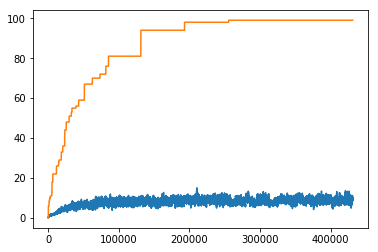

In [3]:
import matplotlib.pyplot as plt
plt.plot(agent.last_100_avg_log)
plt.plot(agent.max_score_log)

In [4]:
csv = open("q-learn_rep.csv", "w") 
#"w" indicates that you're writing strings to the file

columnTitleRow = "last_100_avg, max_score_log\n"
csv.write(columnTitleRow)

for a,b in zip(agent.last_100_avg_log,agent.max_score_log):
    avg = a
    maxscore = b
    row = str(avg) + "," +str(maxscore) + "\n"
    csv.write(row)
csv.close()

In [5]:
len(agent.Q_table)

248